# Discriminative Score — Worked Examples

The **discriminative score** rates how useful a single feature is for separating two groups (label 0 vs label 1). It combines three normalized signals:

$$S = 0.4\,P + 0.4\,E + 0.2\,M$$

| Symbol | Name | Range | What it captures |
|---|---|---|---|
| $P$ | p-value strength | $[0, 1]$ | $\min\!\bigl(1,\;{-\log_{10}(p)}/{10}\bigr)$ — is the difference real? |
| $E$ | effect size | $[0, 1]$ | Cohen's $d$ (continuous) or Cramér's $V$ (categorical), capped at 1 |
| $M$ | mutual information | $[0, 1]$ | Normalized MI between feature and label |

Below, every code cell is preceded by:
1. The **LaTeX formula** it implements
2. A **complete hand-math walkthrough** so you can verify every number

### How to Interpret Each Value (Good vs Bad)

#### P — p-value strength
| P value | Raw p-value | Interpretation |
|---|---|---|
| < 0.05 | p > 0.3 | **Bad.** The difference could easily be random noise. |
| 0.05 - 0.20 | p ~ 0.01 - 0.1 | **Weak.** Some evidence, but not convincing. |
| 0.20 - 0.50 | p ~ 1e-2 to 1e-5 | **Good.** Strong statistical evidence the groups differ. |
| > 0.50 | p < 1e-5 | **Excellent.** Very strong evidence. |

#### E — effect size (Cohen's d or Cramer's V)
| E value | Interpretation |
|---|---|
| < 0.20 | **Negligible.** Groups overlap almost completely. |
| 0.20 - 0.50 | **Small.** Noticeable difference but lots of overlap. |
| 0.50 - 0.80 | **Medium.** Clear practical difference. |
| > 0.80 | **Large.** Groups are well separated. |

#### M — normalized mutual information
| M value | Interpretation |
|---|---|
| < 0.05 | **Bad.** Feature tells you almost nothing about the label. |
| 0.05 - 0.20 | **Weak.** Slight information gain. |
| 0.20 - 0.50 | **Good.** Feature meaningfully reduces uncertainty about the label. |
| > 0.50 | **Excellent.** Feature strongly predicts the label. |

#### S — final discriminative score
| S value | Interpretation |
|---|---|
| < 0.20 | **Drop it.** The feature is not useful for classification. |
| 0.20 - 0.40 | **Weak.** Might help slightly but do not rely on it alone. |
| 0.40 - 0.60 | **Moderate.** A decent feature worth including. |
| 0.60 - 0.80 | **Strong.** Reliable discriminator — prioritize this feature. |
| > 0.80 | **Excellent.** Top-tier feature with high significance, large effect, and high MI. |

In [3]:
%pip install numpy pandas scipy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# ── Library imports ───────────────────────────────────────────
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

---
## Part 1 — Continuous Feature (`enum_state_depth`)

We compare a numeric feature between label 0 and label 1 using a **two-sample t-test**.

In [5]:
# ── Continuous sample data ────────────────────────────────────
df_cont = pd.DataFrame(
    {
        "label": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        "enum_state_depth": [2, 3, 2, 4, 3, 7, 8, 6, 7, 9],
    }
)
# Split into two groups by label
x0 = df_cont.loc[df_cont.label == 0, "enum_state_depth"].values  # [2,3,2,4,3]
x1 = df_cont.loc[df_cont.label == 1, "enum_state_depth"].values  # [7,8,6,7,9]
df_cont

,label,enum_state_depth
0,0,2
1,0,3
2,0,2
3,0,4
4,0,3
5,1,7
6,1,8
7,1,6
8,1,7
9,1,9


### 1a. Sample Means

**Formula:**

$$\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i$$

**Hand math:**

$$\bar{x}_0 = \frac{2+3+2+4+3}{5} = \frac{14}{5} = 2.8$$

$$\bar{x}_1 = \frac{7+8+6+7+9}{5} = \frac{37}{5} = 7.4$$

In [6]:
# ── Compute sample means ──────────────────────────────────────
n0, n1 = len(x0), len(x1)
mean0 = x0.mean()
mean1 = x1.mean()
print(f"n0 = {n0},  n1 = {n1}")
print(f"mean0 = {x0.sum()}/{n0} = {mean0}")
print(f"mean1 = {x1.sum()}/{n1} = {mean1}")

n0 = 5,  n1 = 5
mean0 = 14/5 = 2.8
mean1 = 37/5 = 7.4


### 1b. Sample Variances (Bessel-corrected, ddof=1)

**Formula:**

$$s^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2$$

**Hand math for group 0** ($\bar{x}_0 = 2.8$):

$$s_0^2 = \frac{(2-2.8)^2 + (3-2.8)^2 + (2-2.8)^2 + (4-2.8)^2 + (3-2.8)^2}{5-1}$$

$$= \frac{0.64 + 0.04 + 0.64 + 1.44 + 0.04}{4} = \frac{2.80}{4} = 0.70$$

**Hand math for group 1** ($\bar{x}_1 = 7.4$):

$$s_1^2 = \frac{(7-7.4)^2 + (8-7.4)^2 + (6-7.4)^2 + (7-7.4)^2 + (9-7.4)^2}{5-1}$$

$$= \frac{0.16 + 0.36 + 1.96 + 0.16 + 2.56}{4} = \frac{5.20}{4} = 1.30$$

In [7]:
# ── Compute sample variances (ddof=1) ────────────────────────
var0 = x0.var(ddof=1)
var1 = x1.var(ddof=1)
print(f"var0 = {var0:.2f}")
print(f"var1 = {var1:.2f}")

var0 = 0.70
var1 = 1.30


### 1c. Pooled Variance, t-Statistic, and p-Value

**Degrees of freedom:**

$$df = n_0 + n_1 - 2 = 5 + 5 - 2 = 8$$

> Why $n_0 + n_1 - 2$? Each group's variance uses $n-1$ free values (one is fixed by the mean). Group 0 contributes $n_0 - 1 = 4$ and group 1 contributes $n_1 - 1 = 4$, so $df = 4 + 4 = 8$.

**Pooled variance formula:**

$$s_p^2 = \frac{(n_0-1)\,s_0^2 + (n_1-1)\,s_1^2}{df}$$

**Hand math:**

$$s_p^2 = \frac{4 \times 0.70 + 4 \times 1.30}{8} = \frac{2.80 + 5.20}{8} = \frac{8.00}{8} = 1.00$$

$$s_p = \sqrt{1.00} = 1.00$$

**t-statistic formula:**

$$t = \frac{\bar{x}_1 - \bar{x}_0}{s_p\,\sqrt{\dfrac{1}{n_0} + \dfrac{1}{n_1}}}$$

**Hand math:**

$$t = \frac{7.4 - 2.8}{1.00 \times \sqrt{\frac{1}{5} + \frac{1}{5}}} = \frac{4.6}{\sqrt{0.4}} = \frac{4.6}{0.6325} \approx 7.2761$$

**p-value:** Two-sided probability from the $t$ distribution with $df = 8$:

$$p = 2\,P\!\left(T_{df=8} \ge |7.2761|\right) \approx 0.000088$$

In [8]:
# ── Compute pooled variance, t-statistic, and p-value ────────
df_ttest = n0 + n1 - 2
sp2 = ((n0 - 1) * var0 + (n1 - 1) * var1) / df_ttest
sp = np.sqrt(sp2)
t_stat = (mean1 - mean0) / (sp * np.sqrt(1 / n0 + 1 / n1))
p_cont = 2 * stats.t.sf(abs(t_stat), df_ttest)
print(f"df     = {df_ttest}")
print(f"sp²    = {sp2:.2f},  sp = {sp:.2f}")
print(f"t      = {t_stat:.4f}")
print(f"p      = {p_cont:.6f}")

df     = 8
sp²    = 1.00,  sp = 1.00
t      = 7.2732
p      = 0.000086


### 1d. Cohen's d → Component $E$

**Formula:**

$$d = \frac{\bar{x}_1 - \bar{x}_0}{s_p}$$

**Hand math:**

$$d = \frac{7.4 - 2.8}{1.00} = 4.60$$

The score caps effect size at 1:

$$E = \min(1,\;|d|) = \min(1,\;4.60) = 1.0$$

In [9]:
# ── Compute Cohen's d and component E ────────────────────────
cohens_d = (mean1 - mean0) / sp
E_cont = min(1.0, abs(cohens_d))
print(f"Cohen's d = ({mean1} - {mean0}) / {sp} = {cohens_d:.4f}")
print(f"E = min(1, |{cohens_d:.4f}|) = {E_cont}")

Cohen's d = (7.4 - 2.8) / 0.9999999999999999 = 4.6000
E = min(1, |4.6000|) = 1.0


### 1e. NMI (from binning) → Component $M$

To compute NMI for a continuous feature, we first **bin** it. Use a threshold of 4: Low $(\le 4)$, High $(> 4)$.

**Contingency table after binning:**

| | Low | High | total |
|---|---|---|---|
| label 0 | 5 | 0 | 5 |
| label 1 | 0 | 5 | 5 |
| total | 5 | 5 | 10 |

**Mutual Information formula:**

$$I(X;Y) = \sum_{x,y} p(x,y)\,\ln\!\frac{p(x,y)}{p(x)\,p(y)}$$

**Joint probabilities** (each cell / 10):
- $p(\text{label}=0,\,\text{Low}) = 5/10 = 0.5$
- $p(\text{label}=1,\,\text{High}) = 5/10 = 0.5$
- All other joint cells are 0 (contribute nothing)

**Marginals:**
- $p(\text{label}=0) = 0.5$, $p(\text{label}=1) = 0.5$
- $p(\text{Low}) = 0.5$, $p(\text{High}) = 0.5$

**Hand math:**

$$I = 0.5\,\ln\!\frac{0.5}{0.5 \times 0.5} + 0.5\,\ln\!\frac{0.5}{0.5 \times 0.5} = 0.5\,\ln 2 + 0.5\,\ln 2 = \ln 2 \approx 0.6931$$

**Entropy formula:**

$$H(X) = -\sum_x p(x)\,\ln p(x)$$

$$H(\text{label}) = -[0.5\ln 0.5 + 0.5\ln 0.5] = \ln 2 \approx 0.6931$$

$$H(\text{bin}) = -[0.5\ln 0.5 + 0.5\ln 0.5] = \ln 2 \approx 0.6931$$

**NMI formula:**

$$\text{NMI} = \frac{I}{\sqrt{H(\text{label}) \cdot H(\text{bin})}} = \frac{0.6931}{\sqrt{0.6931 \times 0.6931}} = \frac{0.6931}{0.6931} = 1.0$$

$$M = \text{NMI} = 1.0$$

In [10]:
# ── Compute NMI via binning for the continuous feature ────────
# Bin: 0 = Low (≤4), 1 = High (>4)
binned = (df_cont["enum_state_depth"] > 4).astype(int)
nmi_cont = normalized_mutual_info_score(df_cont["label"], binned)
M_cont = nmi_cont
print(f"Binned values: {binned.values}")
print(f"Labels:        {df_cont['label'].values}")
print(f"NMI = {nmi_cont:.4f}")
print(f"M   = {M_cont:.4f}")

Binned values: [0 0 0 0 0 1 1 1 1 1]
Labels:        [0 0 0 0 0 1 1 1 1 1]
NMI = 1.0000
M   = 1.0000


### 1f. Assemble the Discriminative Score (Continuous)

**P component formula:**

$$P = \min\!\left(1,\;\frac{-\log_{10}(p)}{10}\right)$$

**Hand math** (using $p \approx 0.000088$):

$$-\log_{10}(0.000088) = -(-4.056) = 4.056$$

$$P = \min\!\left(1,\;\frac{4.056}{10}\right) = \min(1,\;0.4056) = 0.4056$$

**Final score formula:**

$$S = 0.4\,P + 0.4\,E + 0.2\,M$$

**Hand math:**

$$S = 0.4 \times 0.4056 + 0.4 \times 1.0 + 0.2 \times 1.0$$

$$S = 0.1622 + 0.4000 + 0.2000 = 0.7622$$

In [11]:
# ── Assemble the discriminative score for the continuous feature
P_cont = min(1.0, -np.log10(p_cont) / 10)
S_cont = 0.4 * P_cont + 0.4 * E_cont + 0.2 * M_cont
print(f"P = min(1, -log10({p_cont:.6f}) / 10) = {P_cont:.4f}")
print(f"E = {E_cont:.4f}")
print(f"M = {M_cont:.4f}")
print(f"S = 0.4x{P_cont:.4f} + 0.4x{E_cont:.4f} + 0.2x{M_cont:.4f} = {S_cont:.4f}")

P = min(1, -log10(0.000086) / 10) = 0.4065
E = 1.0000
M = 1.0000
S = 0.4x0.4065 + 0.4x1.0000 + 0.2x1.0000 = 0.7626


---
## Part 2 — Categorical Feature (`image_file_name`)

We compare a categorical feature across labels using a **chi-square test of independence**.

In [12]:
# ── Categorical sample data ───────────────────────────────────
df_cat = pd.DataFrame(
    {
        "label": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        "image_file_name": [
            "explorer.exe",
            "chrome.exe",
            "explorer.exe",
            "chrome.exe",
            "svchost.exe",
            "evil.exe",
            "evil.exe",
            "evil.exe",
            "cmd.exe",
            "evil.exe",
        ],
    }
)
df_cat

,label,image_file_name
0,0,explorer.exe
1,0,chrome.exe
2,0,explorer.exe
3,0,chrome.exe
4,0,svchost.exe
5,1,evil.exe
6,1,evil.exe
7,1,evil.exe
8,1,cmd.exe
9,1,evil.exe


### 2a. Contingency Table, Expected Counts, Chi-Square, and p-Value

**Observed contingency table:**

| | chrome | cmd | evil | explorer | svchost | row total |
|---|---|---|---|---|---|---|
| label 0 | 2 | 0 | 0 | 2 | 1 | 5 |
| label 1 | 0 | 1 | 4 | 0 | 0 | 5 |
| col total | 2 | 1 | 4 | 2 | 1 | **10** |

**Degrees of freedom:**

$$df = (r-1)(c-1) = (2-1)(5-1) = 1 \times 4 = 4$$

> Why $(r-1)(c-1)$? Once you fix row totals and column totals, only $(r-1)(c-1)$ cells can vary freely — the rest are forced.

**Expected count formula:**

$$E_{ij} = \frac{(\text{row total}_i)(\text{col total}_j)}{n}$$

**Hand math** (each row total is 5, $n = 10$):
- $E_{0,\text{chrome}} = 5 \times 2 / 10 = 1.0$
- $E_{0,\text{cmd}} = 5 \times 1 / 10 = 0.5$
- $E_{0,\text{evil}} = 5 \times 4 / 10 = 2.0$
- $E_{0,\text{explorer}} = 5 \times 2 / 10 = 1.0$
- $E_{0,\text{svchost}} = 5 \times 1 / 10 = 0.5$
- Label 1 expected counts are identical (same row total of 5).

**Chi-square formula:**

$$\chi^2 = \sum_{i,j}\frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

**Hand math** (all 10 cells):

$$\chi^2 = \frac{(2-1)^2}{1} + \frac{(0-0.5)^2}{0.5} + \frac{(0-2)^2}{2} + \frac{(2-1)^2}{1} + \frac{(1-0.5)^2}{0.5}$$

$$\quad + \frac{(0-1)^2}{1} + \frac{(1-0.5)^2}{0.5} + \frac{(4-2)^2}{2} + \frac{(0-1)^2}{1} + \frac{(1-0.5)^2}{0.5}$$

$$= 1 + 0.5 + 2 + 1 + 0.5 + 1 + 0.5 + 2 + 1 + 0.5 = 10.0$$

**p-value** from the $\chi^2$ distribution with $df = 4$:

$$p = P(\chi^2_{df=4} \ge 10.0) \approx 0.0404$$

In [13]:
# ── Build contingency table and compute chi-square ────────────
ct = pd.crosstab(df_cat["label"], df_cat["image_file_name"])
chi2, p_cat, dof, expected = stats.chi2_contingency(ct, correction=False)
print("Observed counts:")
print(ct)
print(f"\ndf = (r-1)(c-1) = ({ct.shape[0]-1})({ct.shape[1]-1}) = {dof}")
print(f"\nExpected counts:")
print(pd.DataFrame(expected, columns=ct.columns, index=ct.index))
print(f"\nχ² = {chi2:.4f}")
print(f"p  = {p_cat:.6f}")

Observed counts:
image_file_name  chrome.exe  cmd.exe  evil.exe  explorer.exe  svchost.exe
label                                                                    
0                         2        0         0             2            1
1                         0        1         4             0            0

df = (r-1)(c-1) = (1)(4) = 4

Expected counts:
image_file_name  chrome.exe  cmd.exe  evil.exe  explorer.exe  svchost.exe
label                                                                    
0                       1.0      0.5       2.0           1.0          0.5
1                       1.0      0.5       2.0           1.0          0.5

χ² = 10.0000
p  = 0.040428


### 2b. Cramér's V → Component $E$

**Formula:**

$$V = \sqrt{\frac{\chi^2}{n\,(\min(r,c) - 1)}}$$

where $r$ = number of rows, $c$ = number of columns.

**Hand math:**

$$k = \min(2, 5) = 2$$

$$V = \sqrt{\frac{10.0}{10 \times (2-1)}} = \sqrt{\frac{10.0}{10}} = \sqrt{1.0} = 1.0$$

$$E = \min(1,\;V) = \min(1,\;1.0) = 1.0$$

In [14]:
# ── Compute Cramér's V and component E ────────────────────────
n_cat = ct.values.sum()
k = min(ct.shape[0], ct.shape[1])
V = np.sqrt(chi2 / (n_cat * (k - 1)))
E_cat = min(1.0, V)
print(f"k = min({ct.shape[0]}, {ct.shape[1]}) = {k}")
print(f"V = sqrt({chi2:.1f} / ({n_cat} x {k-1})) = {V:.4f}")
print(f"E = min(1, {V:.4f}) = {E_cat:.4f}")

k = min(2, 5) = 2
V = sqrt(10.0 / (10 x 1)) = 1.0000
E = min(1, 1.0000) = 1.0000


### 2c. NMI → Component $M$

**Same MI and NMI formulas as Part 1**, but now applied directly to the categorical values (no binning needed).

**Non-zero joint probabilities** (cell count / 10):
- $p(0,\text{chrome}) = 2/10 = 0.2$
- $p(0,\text{explorer}) = 2/10 = 0.2$
- $p(0,\text{svchost}) = 1/10 = 0.1$
- $p(1,\text{cmd}) = 1/10 = 0.1$
- $p(1,\text{evil}) = 4/10 = 0.4$

**Marginals:**
- $p(\text{label}=0) = 0.5$, $p(\text{label}=1) = 0.5$
- $p(\text{chrome}) = 0.2$, $p(\text{explorer}) = 0.2$, $p(\text{svchost}) = 0.1$, $p(\text{cmd}) = 0.1$, $p(\text{evil}) = 0.4$

**Hand math (MI):**

$$I = 0.2\ln\!\frac{0.2}{0.5 \times 0.2} + 0.2\ln\!\frac{0.2}{0.5 \times 0.2} + 0.1\ln\!\frac{0.1}{0.5 \times 0.1} + 0.1\ln\!\frac{0.1}{0.5 \times 0.1} + 0.4\ln\!\frac{0.4}{0.5 \times 0.4}$$

Each term simplifies to $p \cdot \ln 2$:

$$I = (0.2 + 0.2 + 0.1 + 0.1 + 0.4)\ln 2 = 1.0 \times \ln 2 = 0.6931$$

**Entropies:**

$$H(\text{label}) = \ln 2 = 0.6931$$

$$H(\text{feature}) = -[0.2\ln 0.2 + 0.2\ln 0.2 + 0.1\ln 0.1 + 0.1\ln 0.1 + 0.4\ln 0.4]$$

$$= -[2(-0.3219) + 2(-0.2303) + (-0.3665)] = -[-0.6438 - 0.4606 - 0.3665] = 1.4709$$

**NMI:**

$$\text{NMI} = \frac{I}{\sqrt{H(\text{label}) \cdot H(\text{feature})}} = \frac{0.6931}{\sqrt{0.6931 \times 1.4709}} = \frac{0.6931}{1.0094} \approx 0.6867$$

> Note: `sklearn` uses the geometric-mean denominator by default, which is what we use here.

In [15]:
# ── Compute NMI for the categorical feature ──────────────────
nmi_cat = normalized_mutual_info_score(df_cat["label"], df_cat["image_file_name"])
M_cat = nmi_cat
print(f"NMI = {nmi_cat:.4f}")
print(f"M   = {M_cat:.4f}")

NMI = 0.6406
M   = 0.6406


### 2d. Assemble the Discriminative Score (Categorical)

**P component:**

$$P = \min\!\left(1,\;\frac{-\log_{10}(p)}{10}\right)$$

**Hand math** (using $p \approx 0.0404$):

$$-\log_{10}(0.0404) = 1.3937$$

$$P = \min\!\left(1,\;\frac{1.3937}{10}\right) = 0.1394$$

**Final score:**

$$S = 0.4 \times 0.1394 + 0.4 \times 1.0 + 0.2 \times 0.6867$$

$$S = 0.0558 + 0.4000 + 0.1373 = 0.5931$$

In [16]:
# ── Assemble the discriminative score for the categorical feature
P_cat = min(1.0, -np.log10(p_cat) / 10)
S_cat = 0.4 * P_cat + 0.4 * E_cat + 0.2 * M_cat
print(f"P = min(1, -log10({p_cat:.6f}) / 10) = {P_cat:.4f}")
print(f"E = {E_cat:.4f}")
print(f"M = {M_cat:.4f}")
print(f"S = 0.4x{P_cat:.4f} + 0.4x{E_cat:.4f} + 0.2x{M_cat:.4f} = {S_cat:.4f}")

P = min(1, -log10(0.040428) / 10) = 0.1393
E = 1.0000
M = 0.6406
S = 0.4x0.1393 + 0.4x1.0000 + 0.2x0.6406 = 0.5839


---
## Part 3 — Side-by-Side Results and Reusable Function

In [17]:
# ── Side-by-side results table ────────────────────────────────
results = pd.DataFrame(
    {
        "Feature": ["enum_state_depth", "image_file_name"],
        "Type": ["continuous", "categorical"],
        "Test": ["t-test", "chi-square"],
        "Statistic": [f"t={t_stat:.4f}", f"χ²={chi2:.4f}"],
        "df": [df_ttest, dof],
        "p-value": [p_cont, p_cat],
        "Effect Size": [f"d={cohens_d:.2f}", f"V={V:.2f}"],
        "P": [P_cont, P_cat],
        "E": [E_cont, E_cat],
        "M": [M_cont, M_cat],
        "S (score)": [S_cont, S_cat],
    }
)
results.style.format(
    {
        "p-value": "{:.6f}",
        "P": "{:.4f}",
        "E": "{:.4f}",
        "M": "{:.4f}",
        "S (score)": "{:.4f}",
    }
).set_caption("Discriminative Score Breakdown")

,Feature,Type,Test,Statistic,df,p-value,Effect Size,P,E,M,S (score)
0,enum_state_depth,continuous,t-test,t=7.2732,8,0.000086,d=4.60,0.4065,1.0000,1.0000,0.7626
1,image_file_name,categorical,chi-square,χ²=10.0000,4,0.040428,V=1.00,0.1393,1.0000,0.6406,0.5839


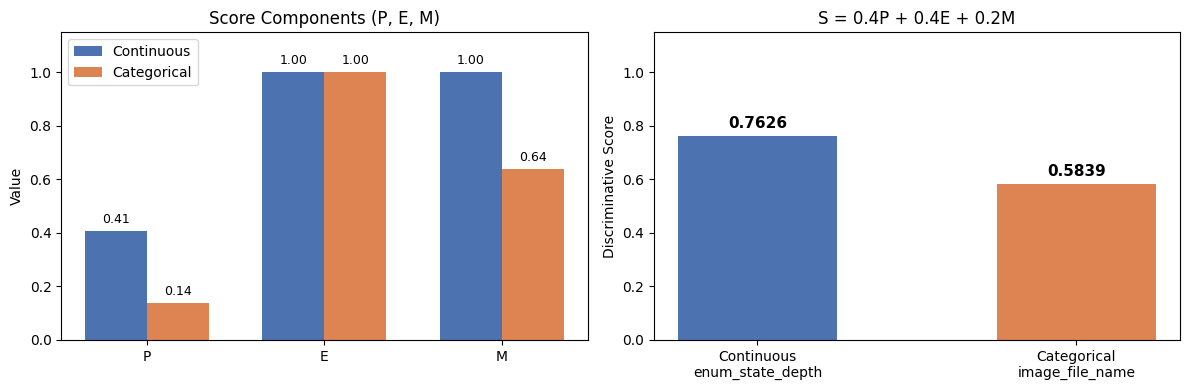

In [18]:
# ── Visualization: component breakdown and final scores ───────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left panel: P, E, M side by side
labels_bar = ["P", "E", "M"]
cont_vals = [P_cont, E_cont, M_cont]
cat_vals = [P_cat, E_cat, M_cat]
x = np.arange(len(labels_bar))
w = 0.35
axes[0].bar(x - w / 2, cont_vals, w, label="Continuous", color="#4C72B0")
axes[0].bar(x + w / 2, cat_vals, w, label="Categorical", color="#DD8452")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels_bar)
axes[0].set_ylim(0, 1.15)
axes[0].set_ylabel("Value")
axes[0].set_title("Score Components (P, E, M)")
axes[0].legend()
for i in x:
    axes[0].text(
        i - w / 2, cont_vals[i] + 0.03, f"{cont_vals[i]:.2f}", ha="center", fontsize=9
    )
    axes[0].text(
        i + w / 2, cat_vals[i] + 0.03, f"{cat_vals[i]:.2f}", ha="center", fontsize=9
    )

# Right panel: final S
bars = axes[1].bar(
    ["Continuous\nenum_state_depth", "Categorical\nimage_file_name"],
    [S_cont, S_cat],
    color=["#4C72B0", "#DD8452"],
    width=0.5,
)
axes[1].set_ylim(0, 1.15)
axes[1].set_ylabel("Discriminative Score")
axes[1].set_title("S = 0.4P + 0.4E + 0.2M")
for bar, val in zip(bars, [S_cont, S_cat]):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.03,
        f"{val:.4f}",
        ha="center",
        fontsize=11,
        fontweight="bold",
    )
plt.tight_layout()
plt.show()

### Reusable Function: `compute_discriminative_score()`

The function below follows these rules:
- Full docstrings on every function
- Max **8 code lines** per function — helpers are used when needed
- Private helpers (prefixed `_`) are defined **above** the main function, in the **exact order** they are called
- The `_` prefix is **only** for functions called inside other functions

In [19]:
def _infer_feature_type(values: pd.Series) -> str:
    """Infer whether a pandas Series is continuous or categorical.

    Returns
    -------
    str
        'continuous' if the dtype is numeric, otherwise 'categorical'.
    """
    return "continuous" if pd.api.types.is_numeric_dtype(values) else "categorical"


def _continuous_stats(
    g0: np.ndarray, g1: np.ndarray, labels: pd.Series, values: pd.Series
) -> tuple:
    """Compute p-value, effect size (Cohen's d), and NMI for a continuous feature.

    Parameters
    ----------
    g0 : np.ndarray
        Feature values for label-0 samples.
    g1 : np.ndarray
        Feature values for label-1 samples.
    labels : pd.Series
        Full label column.
    values : pd.Series
        Full feature column (used for median-split binning).

    Returns
    -------
    tuple
        (p_value, cohens_d, nmi)
    """
    n0, n1 = len(g0), len(g1)
    sp2 = ((n0 - 1) * g0.var(ddof=1) + (n1 - 1) * g1.var(ddof=1)) / (n0 + n1 - 2)
    sp = np.sqrt(sp2)
    _, p = stats.ttest_ind(g0, g1, equal_var=True)
    d = abs(g1.mean() - g0.mean()) / sp if sp > 0 else 0.0
    binned = (values > values.median()).astype(int)
    nmi = normalized_mutual_info_score(labels, binned)
    return p, d, nmi


def _categorical_stats(labels: pd.Series, values: pd.Series, n: int) -> tuple:
    """Compute p-value, effect size (Cramér's V), and NMI for a categorical feature.

    Parameters
    ----------
    labels : pd.Series
        Binary label column.
    values : pd.Series
        Categorical feature column.
    n : int
        Total number of samples.

    Returns
    -------
    tuple
        (p_value, cramers_v, nmi)
    """
    ct = pd.crosstab(labels, values)
    chi2, p, _, _ = stats.chi2_contingency(ct, correction=False)
    k = min(ct.shape)
    v = np.sqrt(chi2 / (n * max(k - 1, 1)))
    nmi = normalized_mutual_info_score(labels, values)
    return p, v, nmi


def _score_components(p_value: float, effect_size: float, nmi: float) -> dict:
    """Normalize raw statistics into the P, E, M components and compute S.

    Parameters
    ----------
    p_value : float
        Raw p-value from the statistical test.
    effect_size : float
        Raw effect size (Cohen's d or Cramér's V).
    nmi : float
        Normalized mutual information.

    Returns
    -------
    dict
        Keys: p_value, effect_size, nmi, P, E, M, S.
    """
    P = min(1.0, -np.log10(max(p_value, 1e-300)) / 10)
    E = min(1.0, effect_size)
    M = nmi
    S = 0.4 * P + 0.4 * E + 0.2 * M
    return {
        "p_value": p_value,
        "effect_size": effect_size,
        "nmi": nmi,
        "P": P,
        "E": E,
        "M": M,
        "S": S,
    }


def compute_discriminative_score(
    df: pd.DataFrame, feature_col: str, label_col: str, feature_type: str = "auto"
) -> dict:
    """Compute the discriminative score for a single feature.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing feature and label columns.
    feature_col : str
        Name of the feature column to evaluate.
    label_col : str
        Name of the binary label column (0 or 1).
    feature_type : str, optional
        'continuous', 'categorical', or 'auto' (default: 'auto').

    Returns
    -------
    dict
        Keys: p_value, effect_size, nmi, P, E, M, S.
    """
    labels, values = df[label_col], df[feature_col]
    if feature_type == "auto":
        feature_type = _infer_feature_type(values)
    if feature_type == "continuous":
        g0 = values[labels == 0].dropna().values
        g1 = values[labels == 1].dropna().values
        p, effect, nmi = _continuous_stats(g0, g1, labels, values)
    else:
        p, effect, nmi = _categorical_stats(labels, values, len(df))
    return _score_components(p, effect, nmi)

In [20]:
# ── Verify the function matches our hand-computed values ──────
score_cont = compute_discriminative_score(df_cont, "enum_state_depth", "label")
score_cat = compute_discriminative_score(df_cat, "image_file_name", "label")
print("Continuous:", {k: round(v, 4) for k, v in score_cont.items()})
print("Categorical:", {k: round(v, 4) for k, v in score_cat.items()})

Continuous: {'p_value': np.float64(0.0001), 'effect_size': np.float64(4.6), 'nmi': 1.0, 'P': np.float64(0.4065), 'E': 1.0, 'M': 1.0, 'S': np.float64(0.7626)}
Categorical: {'p_value': np.float64(0.0404), 'effect_size': np.float64(1.0), 'nmi': 0.6406, 'P': np.float64(0.1393), 'E': 1.0, 'M': 0.6406, 'S': np.float64(0.5839)}
